# Growth and seasonal component analysis

We look at the Mauna Loa observatory measurments of atmospheric $CO_2$, more specifically, the monthly dataset from 1958 to 2019, trying to understand the long-term growth and the monthly seasonality. The dataset can be downloaded [here](http://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo).

In [2]:
# standard imports
%matplotlib inline

from datetime import timedelta
import calendar
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-whitegrid')

# utility function

def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize

## Loading the data

In [3]:
data = pd.read_csv('monthly_in_situ_co2_mlo.csv', header=56)

# missing data is marked as -99.99
data = data.replace(to_replace=-99.99, value=np.nan)
data = data.dropna().reset_index(drop=True)

data.columns = ["year", "month", "_1", "_1", "CO2", "_3", "_4", "_5", "_6", "_7"]
data = data[['year', 'month', 'CO2']]

data = data.assign(date = data.apply(
    lambda row: pd.Timestamp(year=int(row.year), month=int(row.month), day=1), 
    axis=1))
data = data.sort_values('date').reset_index(drop=True)

# standardized years
t = np.arange(data.year.min(), data.year.max() + 1)
t = (t - t.mean()) / t.std()

data.head(5)

,year,month,CO2,date
0,1958,3,315.70,1958-03-01
1,1958,4,317.45,1958-04-01
2,1958,5,317.51,1958-05-01
3,1958,7,315.86,1958-07-01
4,1958,8,314.93,1958-08-01


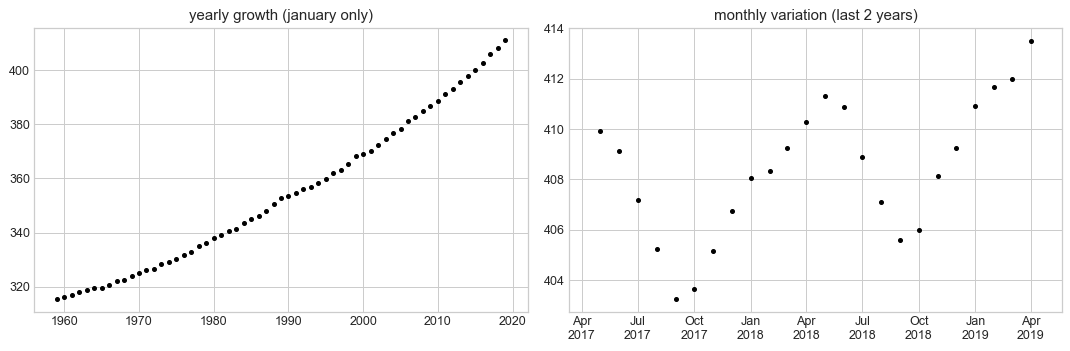

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=90)
ax1.scatter(data[data.month == 1].year, data[data.month == 1].CO2, marker='.', c='k')
ax1.set(title='yearly growth (january only)')
ax2.scatter(data.date[-24:], data.CO2[-24:], marker='.', c='k')
ax2.set(title='monthly variation (last 2 years)')
ax2.xaxis.set_major_formatter(DateFormatter('%b\n%Y'))
fig.tight_layout()
None

## Model

We use a two-component model:

$$ CO_2 = \bar{CO_2} + \sigma_{CO_2} yearly_t + monthly_m $$

* (Positive) Exponential growth $y$ on a yearly level $t$ (standardized years):

$$ y_t = y_0 + e^{a + b t} $$

$$ y_0 \sim \text{Normal}(0, 2) $$

$$ a \sim \text{Normal}(0, 2) $$

$$ b \sim \text{Normal}(0, 1), b > 0 $$

The purpose of this model is to demonstrate a way to use Fourier decomposition with Bayesian inference, so for the yearly trend we will just use this simple explonential growth model.

* Seasonal component $monthly$ modeled with a Fourier transorm:

$$ monthly_m = \sum_{k=0}^{11}\big( {S_k \sin{\frac{2 \pi k m}{12}} + C_k \cos{\frac{2 \pi k m}{12}  } }\big) $$

We will let the model determine the coefficients, but assume that for each mode the two coefficients $S_k, C_k$ are covariate. The covariance will be drawn them from a hyper-prior:

$$ \big({ S_k, C_k }\big) \sim \text{Normal}(0, \text{cholesky_covariance} = K) $$

$$ K \sim \text{LKJCholesky}(\eta=1, \sigma \sim \text{Exponential}(1/2) ) $$

* Finally, for the inference, we will use normal likelihood:

$$ \text{observed} \sim \text{Normal}(CO_2, \sigma) $$

$$ \sigma \sim \text{HalfCauchy}(1) $$

In [5]:
with pm.Model() as m1:

    # exponential growth
    a = pm.Normal('a', mu=0, sd=2)
    b = pm.Bound(pm.Normal, lower=0)('b', mu=0, sd=1)
    y0 = pm.Normal('y0', mu=0, sd=2)

    yearly = pm.Deterministic(
        'yearly',
        y0 + pm.math.exp(a + b * t)
    )

    # monthly seasonality
    K_monthly = pm.LKJCholeskyCov(
        'K_monthly', n=2, eta=1,
        sd_dist=pm.Exponential.dist(lam=1/2., shape=2)
    )
    coef = pm.MvNormal(
        'coef', mu=0,
        chol=pm.expand_packed_triangular(2, K_monthly),
        shape=(12, 2)
    )
    sk = pm.Deterministic('sk', coef[:, 0])
    ck = pm.Deterministic('ck', coef[:, 1])

    comps = []
    monthly = 0
    for i, k in enumerate(range(12)):
        phi = 2 * np.pi * k * np.arange(0, 13) / 12 
        sin_comp = sk[i] * pm.math.sin(phi)
        cos_comp = ck[i] * pm.math.cos(phi)
        comps.append(sin_comp)
        comps.append(cos_comp)
        monthly = monthly + sin_comp + cos_comp

    monthly = pm.Deterministic('monthly', monthly)

    # the single components
    comps = pm.Deterministic('components', pm.math.stack(comps))

    # putting it together
    year_i = data.year.values - data.year.min()
    co2 = pm.Deterministic(
        'co2',
        data.CO2.mean()
        + data.CO2.std() * yearly[year_i]
        + monthly[data.month.values - 1]
    )

    # inference
    sigma = pm.HalfCauchy('sigma', beta=1)
    obs = pm.Normal('obs', mu=co2, sd=sigma,
                    observed=data.CO2.values)

    m1.name = 'expo'
    m1.trace = pm.sample(5000, tune=2500, chains=2)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


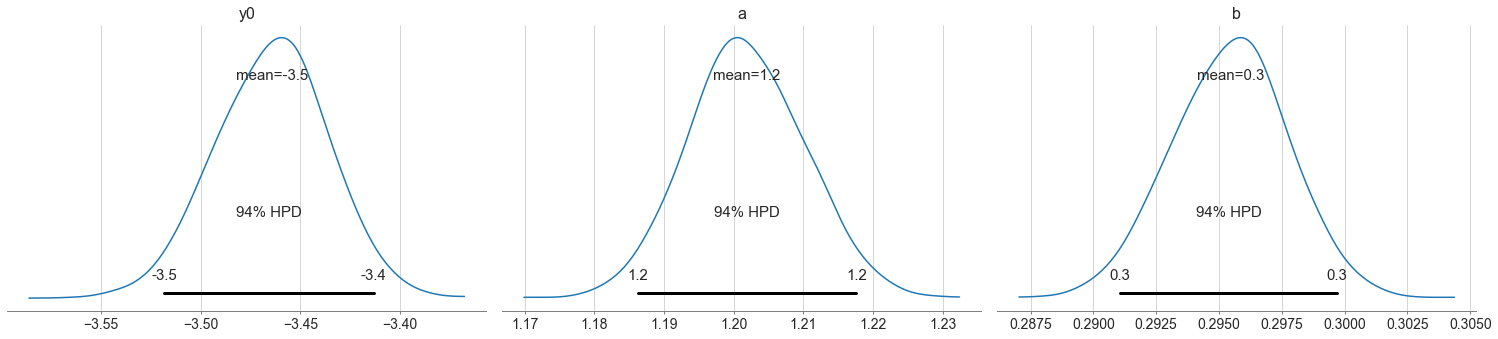

In [7]:
pm.plot_posterior(m1.trace, var_names=['y0', 'a', 'b'])
None

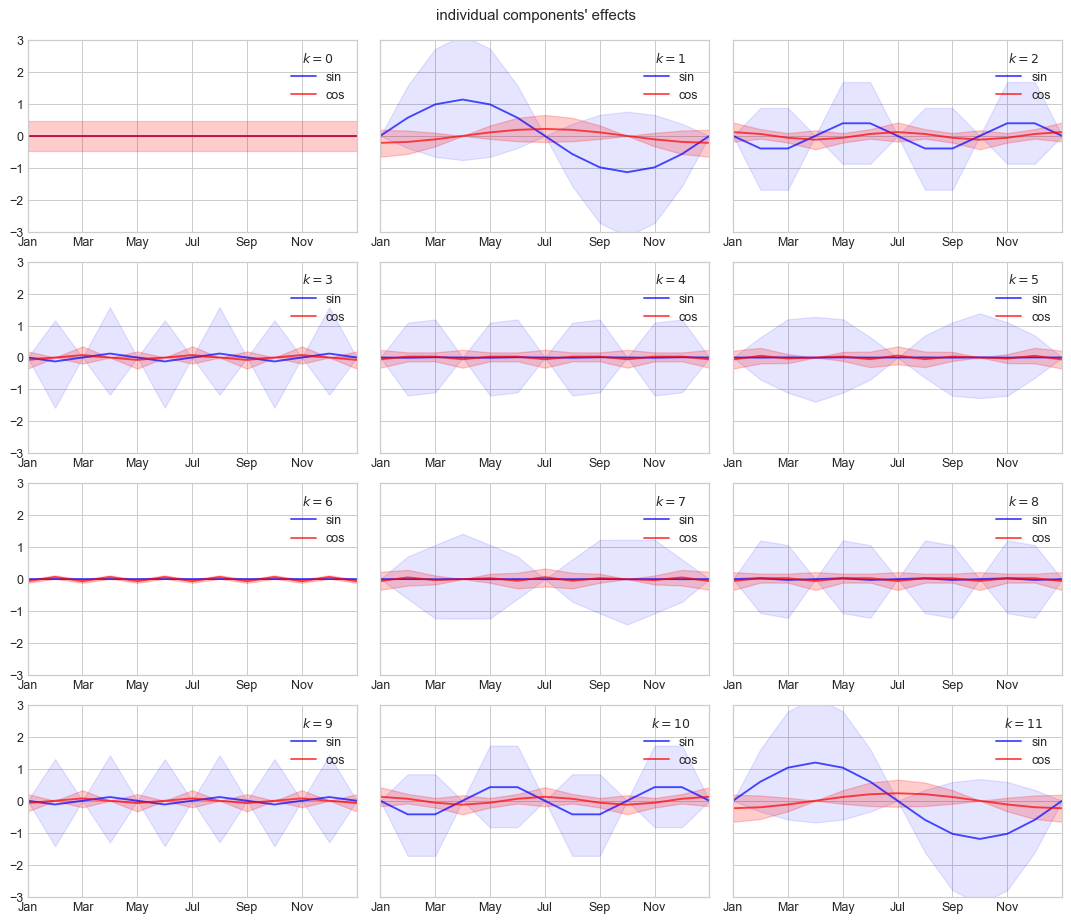

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(12, 10), dpi=90, sharey=True)
axes = axes.reshape(-1)

for i, (k, ax) in enumerate(zip(range(12), axes)):
    tr = pd.DataFrame(m1.trace['components'][:, 2*i, :]).apply(summarize()).T
    ax.plot(tr.mean_, label='sin', color='b', alpha=.7)
    ax.fill_between(tr.index, tr.lower, tr.upper,
                    alpha=.1, color='b', label='')
    tr = pd.DataFrame(m1.trace['components'][:, 2*i+1, :]).apply(summarize()).T
    ax.plot(tr.mean_, label='cos', color='r', alpha=.7)
    ax.fill_between(tr.index, tr.lower, tr.upper,
                    alpha=.2, color='r', label='')
    ax.legend(title=f'$k={k}$')
    ax.set(xlim=(0, 12), ylim=(-3, 3),
           xticklabels=[calendar.month_abbr[i] for i in range(1, 13, 2)])

fig.tight_layout()
fig.suptitle("individual components' effects", y=1.02)
None

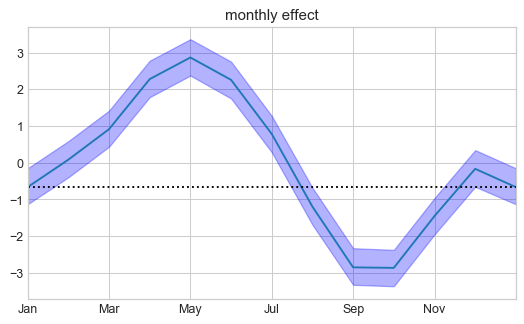

In [9]:
tmp = pd.DataFrame(m1.trace['monthly']).apply(summarize()).T
plt.figure(figsize=(7, 4), dpi=90)
plt.plot(tmp.mean_)
plt.fill_between(tmp.index, tmp.lower, tmp.upper, alpha=.3, color='b')
plt.axhline(tmp.mean_[0], linestyle=':', color='k')
plt.gca().set(xlim=(0, 12), title='monthly effect',
              xticklabels=[calendar.month_abbr[i] for i in range(1, 13, 2)])
None

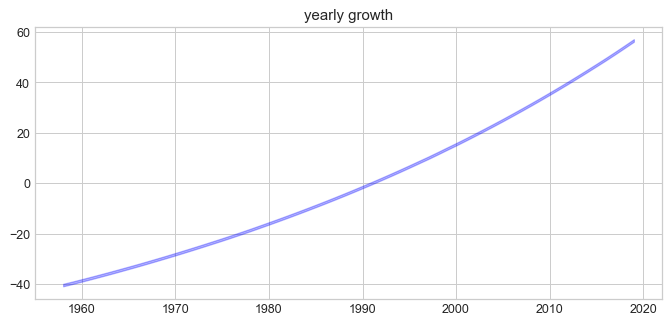

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4), dpi=90)

tmp = pd.DataFrame(m1.trace['yearly']).apply(summarize()).T
ax.fill_between(tmp.index.values + data.year.min(),
                 data.CO2.std() * tmp.lower,
                 data.CO2.std() * tmp.upper,
                 alpha=.3, color='b')
ax.set(title='yearly growth')
None

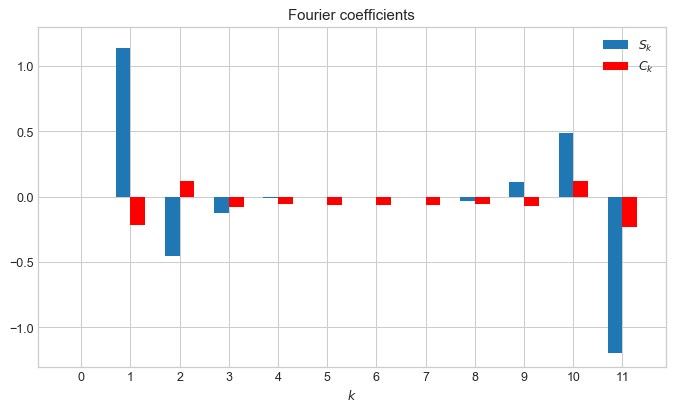

In [11]:
plt.figure(figsize=(9, 5), dpi=90)

tmps = pd.DataFrame(m1.trace['sk']).apply(summarize()).T
tmpc = pd.DataFrame(m1.trace['ck']).apply(summarize()).T

plt.bar(tmps.index - .15, tmps.mean_, width=.3, label='$S_k$')
plt.bar(tmpc.index + .15, tmpc.mean_, width=.3, color='r', label='$C_k$')
plt.gca().set(xticks=range(12), xlabel='$k$', ylim=(-1.3, 1.3),
              title='Fourier coefficients')
plt.legend()

None

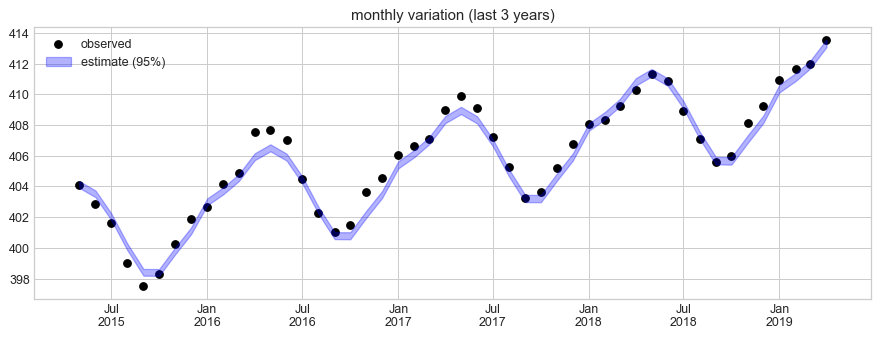

In [12]:
tmp = pd.DataFrame(m1.trace['co2'][:, -48:]).apply(summarize()).T
plt.figure(figsize=(12, 4), dpi=90)
plt.scatter(data.date[-48:], data.CO2[-48:],
            label='observed', c='k')
plt.fill_between(data.date[-48:], tmp.lower, tmp.upper,
                 alpha=.3, color='b', label='estimate (95%)')
plt.gca().set(title='monthly variation (last 3 years)')
plt.gca().xaxis.set_major_formatter(DateFormatter('%b\n%Y'))
plt.legend()
None

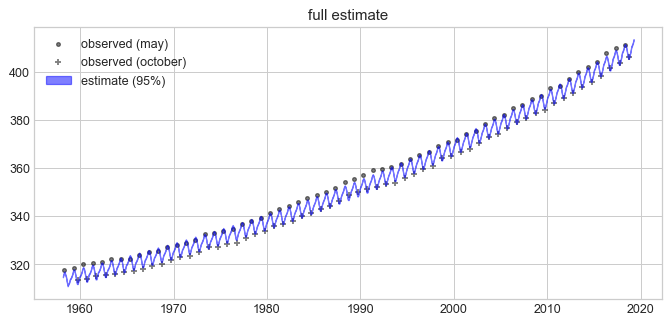

In [13]:
tmp = pd.DataFrame(m1.trace['co2']).apply(summarize()).T
plt.figure(figsize=(9, 4), dpi=90)
plt.scatter(data[data.month == 5].date, data[data.month == 5].CO2,
            marker='.', alpha=.5, color='k', label='observed (may)')
plt.scatter(data[data.month == 10].date, data[data.month == 10].CO2,
            marker='+', s=19, alpha=.5, color='k', label='observed (october)')
plt.fill_between(data.date, tmp.lower, tmp.upper,
                 alpha=.5, color='b', label='estimate (95%)')
plt.gca().set(title='full estimate')
plt.legend()
None